In [1]:
from langgraph.graph import StateGraph

from utils.tools import GraphState  # 图结构数据类型声明
from langgraph.graph import END
from utils.function_tools import route_question, call_model, call_model_SQL_prompt, call_model_SQL_vanna, call_model_SQL, label_predict_SQL
from rag_text import call_model_raglaw
from utils.enhencement_functions import route_question_enhencement


workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("answer_directly", call_model)  # web search
workflow.add_node("retrieve_SQL_prompt", call_model_SQL_prompt)
#workflow.add_node("retrieve_SQL", call_model_SQL_vanna)  # retrieve， 第一种vanna方案
workflow.add_node("retrieve_SQL", call_model_SQL)  #第二种SQL查询方案，用langchain自带方法, 方案切换只需要注释掉其中一个节点即可
workflow.add_node("retrieve_law", call_model_raglaw)
workflow.add_node("SQL_enhencement", label_predict_SQL)
workflow.add_node("enhencement_processing", call_model)

# Define the edges
workflow.add_edge("answer_directly", END)
#workflow.add_edge("retrieve_SQL_prompt", "retrieve_SQL")
workflow.add_edge("retrieve_SQL", END)
workflow.add_edge("retrieve_law", END)
workflow.add_edge("SQL_enhencement", "enhencement_processing")
workflow.add_edge("enhencement_processing", END)

# Build graph
workflow.set_conditional_entry_point(
    route_question,
    {
        "answer_directly": "answer_directly",
        "vectorstore": "retrieve_SQL_prompt",
        "law_query": "retrieve_law",
    },
)


workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "retrieve_SQL_prompt",
    # Next, we pass in the function that will determine which node is called next.
    route_question_enhencement,
    {
        "no_enhencement": "retrieve_SQL",
        "enhencement": "SQL_enhencement"
    
    },
)
graph = workflow.compile()


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
C:\Users\30387\anaconda3\envs\shanghaiproject\lib\site-packages\langsmith\client.py:354: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


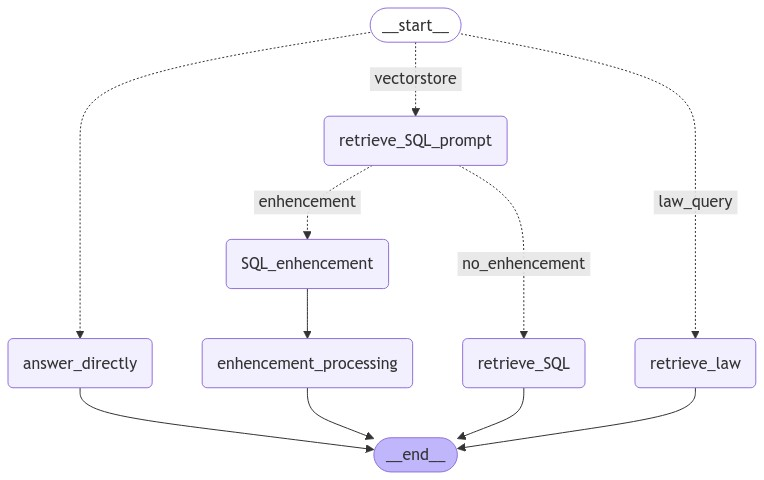

In [2]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))